This notebooks uses the following dataset <br>
https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures

# 1. Analysis of the Problem 

## Understand the problem

working hypothesis
think about model architecture
loss function
and loss criteria

select a measure of success
    Detect all classes/types of hand gestures with a high accuracy
    Classification Problem
    Check whether class-imbalanced problems

Dataset with class of the hand gesture/'Class' (our target value) the person which performed the hand gesture ('User') and a 
feature vector that consists 11 subvectors. Each subvector contains X, Y and Z coordinates. Those coordinates belong to one of the detected markes on the hand glove the user is wearing

* motion capture camera records 12 users performing 5 hand postures with markers attached to a left-handed glove
* rigid pattern of markers on the back of the glove -> establish local coordinate system for the hand
* 11 markers were attached to the thumb and fingers of the glove
* there is no a priori correspondence between the markers of two given records
* due to the resolution of the capture volume and self-occlusion due to the orientation and configuration of the hand and fingers, many records have missing markers.
    -> the number of visible markers in a record varied considerably.


The Problem:
We cannot easily apply traditional approaches because of two properties of point clouds:
* unordered collection (Point 1 with X,Y and Z coordinates could refer to the thh )
* the size of the point cloud varies (due to occlusion, etc.)

## Useful Information from the authors/paper

Class label:<br>
1=Fist(with thumb out), 2=Stop(hand flat), 3=Point1(point with pointer finger), 4=Point2(point with pointer and middle fingers), 5=Grab(fingers curled as if to grab)


Preprocessing:<br>
all markers were transformed to the local coordinate system of the record containing them.

Reduce number of records:<br>
each transformed marker with a norm greater than 200 millimeters was pruned. 
records that contained fewer than 3 markers was removed. 
the data has at most 12 markers per record and at least 3

Be careful:<br>
It is likely that for a given record and user there exists a near duplicate record originating from the same user.
-> evaluate on leave-one-user-out basis wherein

## Ideas I want to try out


**My goal**

* able to predict which gesture a person is performing

* achieve a high accuracy

**My idea/approach**

* 1.approach: extract features that are meaningful for a given data point, train conventional models

* 2.approach: use models that are adapted to point clouds and have been developed specifically for this data

# 2. Data Exploration and Preparation

Check for missing values, NaN values or features,
uniqueness of the data (is it as it was expected to be)
understand the variations in the data (statistical tools)
outliers?
Is it possible to combine features?
Do you have unnecessary features? (a column which gives no information – for instance name
column– or a feature you consider unrelated to the problem)
Check the correlation matrix. It will tell you how much the features are related. You may say,
for instance, there is a great potential to reduce number of dimensions.
scale data (for example, in the [-1, 1] range).

## Preparing the enviroment

In [111]:
#%reload_ext autoreload
#%autoreload 2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
import time
import pickle
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import Tuple
#from sklearn.decomposition import PCA
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# My custom functions
from scripts import analyze_helper, visualisation

# Utility functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, average_precision_score, recall_score, f1_score
from sklearn import preprocessing as pp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
from os.path import dirname, abspath, join

# Models we want to use
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Write utility functions I want to use multiple times

In [112]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred):

    plt.clf()

    class_labels = ['Fist', 'Stop', 'Point1', 'Point2', 'Grab']
    cf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5])
    
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    #normalize
    cf_matrix = (cf_matrix.T/cf_matrix.sum(axis=1)).T
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(5,5)

    custom_cmap = sns.light_palette("#009682", as_cmap=True)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=custom_cmap, xticklabels=class_labels, yticklabels=class_labels, cbar=False)
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [113]:
class Report:

    report: dict

    def __init__(self, model_name:str, model, X_test, y_test, description:list=[]):
        self.X_test = X_test
        self.y_test = y_test
        self.description = description
        self.model_name = model_name

        self.report = self.create_report(model)


    def create_report(self, model):

        try:
            if type(model) == keras.Sequential:
                y_score = model.predict(self.X_test)
            else:
                y_score = model.predict_proba(self.X_test)
        except AttributeError:
            print('No report possible, because no predict_proba method')
            report = None
            return
        y_score_2 = model.predict(self.X_test)
        print(y_score.shape)
        print(y_score_2.shape)
        print(self.y_test.shape)
        print(self.y_test)
        try:
            report = classification_report(self.y_test, y_score_2, output_dict=True)
        except ValueError:
            print('Compute argmax first of y_pred')
            y_score_2 = to_categorical(np.argmax(y_score_2, axis=1))
            report = classification_report(self.y_test, y_score_2, output_dict=True)
            print('TEST')

        return report
    
    def get_report_as_df(self, df_to_save_to:pd.DataFrame):
        'Get the report as a dataframe'

        new_row = {'model': self.model_name,
                   'Accuracy': round(self.report["accuracy"],6), 
                   'Precision': round(self.report["macro avg"]["precision"],5),
                   'Recall': round(self.report["macro avg"]["recall"],6),
                   'F1_score': round(self.report["macro avg"]["f1-score"],6)} 
        df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)

        return df_to_save_to


    def __str__(self):

        if self.report is None:
            print('No return possbile')
            return 'No valid return'

        pattern = '''
        ***********************REPORT*******************************
        Average (macro) precision: {}
        Average accuracy: {}
        Average (macro) recall: {}
        Average (macro) f1-score: {}
        Description {}
        ************************************************************
        '''
        return pattern.format(round(self.report["macro avg"]["precision"],5), round(self.report["accuracy"],6), round(self.report["macro avg"]["recall"],6), round(self.report["macro avg"]["f1-score"],6), ', '.join(self.description))

## Loading the Data

In [114]:
file_path_raw = os.path.join('data', 'Postures.csv')
df_raw = pd.read_csv(file_path_raw, sep=',', na_values='?')

## Understand the Data

### Choose a metric

To choose a metric we have to check whether the classes are balenced/unbalanced

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

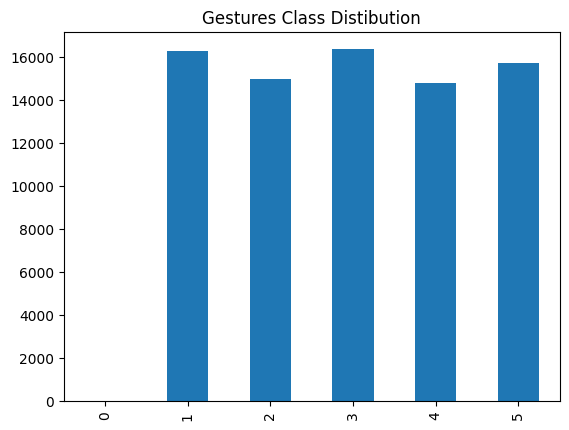

In [115]:
class_counts = df_raw['Class'].value_counts(sort=False)
class_counts.plot(kind='bar', title='Gestures Class Distibution')
plt.show()

To jugde the model perfomance we will choose a mixture of multiple metrics:
* Confusion Matrix
* Accuracy (we have balanced classes!)
* Recall (made TP predictions divided by possible TP predictions)
* precission-recall plot
* F1-Score (harmonic mean between recall and precision, combines the two metrics into one value)

TODO 
Maybe Later
* ROC AUC (Receiver Operator Characteristic — Area Under the Curve, we want a high TPR with a low FPR)
Note: we will use the One vs Rest strategy for ROC AUC (because it is usally a metric for binary classification)

Write utility function to use the ROC AUC for multiclass classficiation

In [116]:
def precision_recall_multiclass(model, X_test, y_test):

    plt.clf()

    y_score = model.predict_proba(X_test)
    y_score_2 = model.predict(X_test)
    
    #print('Amount and Distribution of Test Data: \n', y_test.value_counts())
    y_bin = pp.label_binarize(y_test, classes=model.classes_)

    precision = dict()
    recall = dict()
    average_precision = dict()
    classes = model.classes_

    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
        #print('\n average precision: ', classes[i], ': ', average_precision[i])
        try:
            plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(classes[i]))
        except Exception as e:
            print(e)

    
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

## Data Exploration

In [117]:
df_raw.columns

Index(['Class', 'User', 'X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2',
       'X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6',
       'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10',
       'Z10', 'X11', 'Y11', 'Z11'],
      dtype='object')

In [118]:
# Check which columns have missing values
print(f"Missing values in: {analyze_helper.check_for_missing_vals(df_raw)}")
# Compute missing ratio, hide columns with no missing values (0.0%)
analyze_helper.compute_missing_ratio(df_raw)

Missing values in: ['X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11']


X3      0.88
Y3      0.88
Z3      0.88
X4      4.00
Y4      4.00
Z4      4.00
X5     16.68
Y5     16.68
Z5     16.68
X6     33.10
Y6     33.10
Z6     33.10
X7     50.13
Y7     50.13
Z7     50.13
X8     60.86
Y8     60.86
Z8     60.86
X9     69.31
Y9     69.31
Z9     69.31
X10    81.11
Y10    81.11
Z10    81.11
X11    99.96
Y11    99.96
Z11    99.96
Name: percent_missing, dtype: float64

Hint 1 for preprocessing:
drop the coordinates (X,Y,Z) for point 10 and 11

In [119]:
df_raw = df_raw.fillna(0)

In [120]:
df_raw.head(5)
df_raw.drop([0], inplace=True)
df_raw.reset_index(drop=True, inplace=True)

In [121]:
print('Number of Instances  : ', df_raw.shape[0])
print('Number of Attributes : ', df_raw.shape[1])
print('Number of target classes   : ', df_raw['Class'].nunique()-1)
print('Number of users   : ', df_raw['User'].nunique())

Number of Instances  :  78095
Number of Attributes :  38
Number of target classes   :  4
Number of users   :  14


The description says the data set contains 12 User. No information provided (why are 14 user in the data?).
Hint for us to drop User 4 and 7 ?
They both have signifiantly less data points

In [122]:
user_group = df_raw.groupby(['User'], sort=False)
user_group.count()

,Class,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
User,,,,,,,,,,,,,,,,,,,,,
0,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,...,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048
1,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,...,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717
2,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,...,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513
4,379,379,379,379,379,379,379,379,379,379,...,379,379,379,379,379,379,379,379,379,379
5,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,...,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105
6,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,...,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377
7,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492
8,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,...,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811
9,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,...,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920


In [123]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78095 entries, 0 to 78094
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   78095 non-null  int64  
 1   User    78095 non-null  int64  
 2   X0      78095 non-null  float64
 3   Y0      78095 non-null  float64
 4   Z0      78095 non-null  float64
 5   X1      78095 non-null  float64
 6   Y1      78095 non-null  float64
 7   Z1      78095 non-null  float64
 8   X2      78095 non-null  float64
 9   Y2      78095 non-null  float64
 10  Z2      78095 non-null  float64
 11  X3      78095 non-null  float64
 12  Y3      78095 non-null  float64
 13  Z3      78095 non-null  float64
 14  X4      78095 non-null  float64
 15  Y4      78095 non-null  float64
 16  Z4      78095 non-null  float64
 17  X5      78095 non-null  float64
 18  Y5      78095 non-null  float64
 19  Z5      78095 non-null  float64
 20  X6      78095 non-null  float64
 21  Y6      78095 non-null  float64
 22

### Data Visualization

In [124]:
def pltHand(handPoints):
    plt.close('all')
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    for i in range(11):
        pntx = f'X{i}'
        pnty = f'Y{i}'
        pntz = f'Z{i}'
        
        if(handPoints[pntx].values[0] == 0 or
            handPoints[pnty].values[0] == 0 or
            handPoints[pntz].values[0] == 0):
            n = 0;
        else:
            xlocation = handPoints[pntx]
            ylocation = handPoints[pnty]
            zlocation = handPoints[pntz]
            ax.scatter(xlocation, ylocation, zlocation, marker='v')
    
    crntClass = handPoints['Class'].values[0]
    if (crntClass == 1):
        title = 'Fist + Thumb out'
    if(crntClass == 2):
        title = 'Stop/Flat hand'
    if (crntClass == 3):
        title = 'Point with pointer finger'
    if (crntClass == 4):
        title = 'Point with pointer + middle finger'
    if (crntClass == 5):
        title = 'Grab'
    
    plt.title(title)
    plt.show()


In [125]:
#TODO create a rotateable 3D plot

In [126]:
# Plot a random hand gesture from the dataset to get a an idea of the data
#TODO not working on linux, check why
'''
for _ in range(4):
    rand_dp = np.random.randint(df_raw.shape[0], size=1)[0]
    pltHand(df_raw[rand_dp:rand_dp+1] )
'''

'\nfor _ in range(4):\n    rand_dp = np.random.randint(df_raw.shape[0], size=1)[0]\n    pltHand(df_raw[rand_dp:rand_dp+1] )\n'

In [127]:
def correlation_matrix(df: pd.DataFrame):

    correlationMatrix = pd.DataFrame(df_raw).corr() 
    f = plt.figure(figsize=(12, 6))
    plt.matshow(correlationMatrix, fignum=f.number)
    plt.xticks(range(df_raw.shape[1]), df_raw.columns, fontsize=14, rotation=75)
    plt.yticks(range(df_raw.shape[1]), df_raw.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

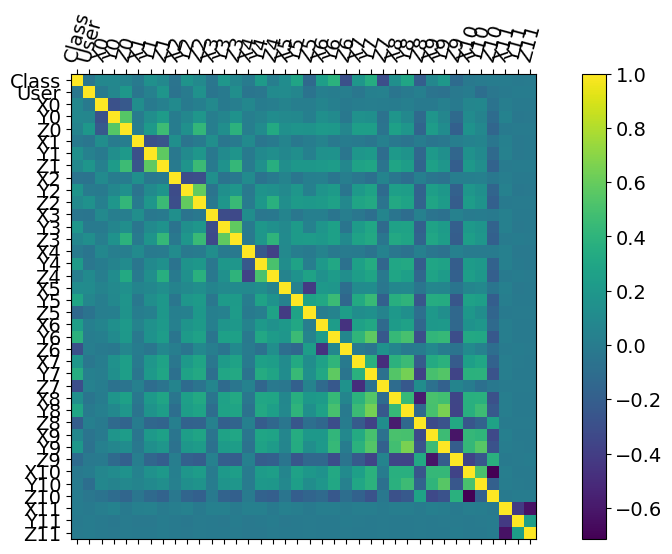

In [128]:
correlation_matrix(df_raw)

## Pre-processing



### General

In [129]:
# Drop rows of user 4 and 7
# Because they have significantly less data points
df_raw = df_raw[df_raw['User'] != 4]
df_raw = df_raw[df_raw['User'] != 7]
df_raw.reset_index(drop=True, inplace=True)

In [130]:
# Drop coordinates of point 10 and 11
# More than 90% of the data is missing
# Search for "Hint 1" for further information
df_raw.drop(['X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11'], inplace=True, axis=1)

### PCA

In [131]:
# TODO compute PCA and plot the data

### Preparing Dataset

### a. Extract features (min, max, mean, etc.) - df_aggregate

Ideas for new features: (inspired from paper)<br>
* number of markers
* mean (per coordinate)
* Eigenvalues and vectors of the points covariance matrix
https://math.stackexchange.com/questions/2842830/why-does-the-eigen-decomposition-of-the-covariance-matrix-of-a-point-cloud-give
* dimensions of the axis-aligned minimum bounding box centered on the mean

Keep in mind that each feature has to aggregate the points in such a way that the result is order invariant!


In [132]:
# New data set we want to fill step by step
df_aggregate= pd.DataFrame()
# We dont want to change the original data set
df_raw_dummy = df_raw.copy(deep=True)

# Save the user and class column
df_user = df_raw_dummy.pop('User')
df_class = df_raw_dummy.pop('Class')


In [133]:
# Extract the X, Y and Z columns
df_x = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('X')]]
df_y = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('Y')]]
df_z = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('Z')]]

In [134]:
# Extract the mean of the X, Y and Z columns
for coordinate in ['X', 'Y', 'Z']:
    df_aggregate[f'{coordinate}_mean'] = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith(coordinate)]].mean(axis=1)

In [135]:
# Extract the number of visible points (not occluded)
df_aggregate['n_points'] = (df_raw_dummy.astype(bool).sum(axis=1))/3
df_aggregate

,X_mean,Y_mean,Z_mean,n_points
0,31.220158,27.403799,-33.548944,5.0
1,32.392560,27.823996,-32.104566,5.0
2,32.081207,27.936918,-32.385520,5.0
3,31.719552,27.575915,-32.964177,5.0
4,31.594851,27.416170,-33.195235,5.0
...,...,...,...,...
77219,27.823671,97.288106,-29.054040,10.0
77220,28.021968,97.191781,-29.248339,10.0
77221,28.103645,96.953570,-29.735080,10.0
77222,20.384035,93.649845,-25.356364,9.0


In [136]:
df_raw_dummy

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9
0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,-52.919272,85.232264,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,-69.982489,87.450873,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,-70.658489,86.835388,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,-72.228461,61.596157,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,-72.574743,86.368748,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,54.251127,129.177414,-44.252511,27.720784,107.810661,11.099282,-1.270139,122.758679,-46.460186,-1.901940,...,-17.150292,-22.833830,104.593913,-53.126136,61.494952,101.205748,-6.543115,87.733364,61.216363,-62.126278
77220,54.334883,129.253842,-44.016320,27.767911,107.914808,11.069842,-30.334054,77.858214,-17.002723,-22.743924,...,4.248334,61.390015,101.468284,-5.985371,88.177233,60.780642,-62.130563,78.229847,33.078407,-45.249543
77221,54.151540,129.269502,-44.173273,27.725978,108.034006,11.020347,-22.574718,104.222208,-53.939140,-30.225675,...,-46.796054,88.291029,60.362768,-62.718735,-1.779495,98.089459,3.835904,78.591554,32.327738,-46.166556
77222,27.915311,108.007390,10.814957,-0.910435,122.464093,-47.271248,-30.084588,77.705861,-17.460853,26.715915,...,-43.967820,-1.581415,98.017411,3.394291,88.465709,60.050791,-63.221626,0.000000,0.000000,0.000000


My idea:<br>
find the orientation of a given cluster<br>
(https://math.stackexchange.com/questions/2842830/why-does-the-eigen-decomposition-of-the-covariance-matrix-of-a-point-cloud-give)

1. Rearange the dataset (1 point per row with X, Y, Z value)
-> All points per row will be saved in a batch as new sub dataframe
2. Compute the covariance matrix for each sub dataframe
3. Calculate the Eigenvalues and Eigenvectors of the covariance matrix
4. Concat created features to the dataframe


DISCLAIMER: <br>
The following function can take up to 1 min!

In [137]:

# Assume you have a DataFrame called 'df' with the columns ['X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']
# Reorganize the dataframe to have each row as a batch of data
# 'X0', 'Y0', 'Z0',
# 'X1', 'Y1', 'Z1',
# 'X2', 'Y2', 'Z2'

# Create an empty list to store the batches of data
batches = []

# Iterate over the DataFrame and extract the batches of data
for row in range(0, df_raw_dummy.shape[0]):

    col_batch = []
    # Extract a batch of data for the current row
    for col in range(0, df_raw_dummy.shape[1], 3):
        batch = df_raw_dummy.iloc[row, col:col+3]
        # Rename the columns
        batch.index = ['X', 'Y', 'Z']
        #print(f'batch: {batch}')
        col_batch.append(batch)
    # Append the batch to the list
    batches.append(col_batch)

# Concatenate the batches of data under each other
concat_batches = []
for batch in batches:
    concat_batch = pd.concat(batch, axis=1).transpose()
    concat_batches.append(concat_batch)
    # Remove rows with all zeros
    concat_batch = concat_batch[(concat_batch.T != 0).any()]

# Create a dictionary with the eigenvalues and eigenvectors as values
eigen_dict = {'eigenvec_1_1': [],
                'eigenvec_1_2': [],
                'eigenvec_1_3': [],
                'eigenvec_2_1': [],
                'eigenvec_2_2': [],
                'eigenvec_2_3': [],
                'eigenvec_3_1': [],
                'eigenvec_3_2': [],
                'eigenvec_3_3': [],
              'eigenval_1': [],
              'eigenval_2': [],
              'eigenval_3': []}

# Create the DataFrame
eigen_df = pd.DataFrame(eigen_dict)

# Compute the covariance matrix for each batch
for concat_batch in concat_batches:
    # Compute the covariance matrix
    cov_matrix = np.cov(concat_batch, rowvar=False)
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Add the eigenvalues and eigenvectors to the DataFrame
    # Store eigenvector 1
    eigen_dict['eigenvec_1_1'].append(eigenvectors[0, 0])
    eigen_dict['eigenvec_1_2'].append(eigenvectors[1, 0])
    eigen_dict['eigenvec_1_3'].append(eigenvectors[2, 0])
    # Store eigenvector 2
    eigen_dict['eigenvec_2_1'].append(eigenvectors[0, 1])
    eigen_dict['eigenvec_2_2'].append(eigenvectors[1, 1])
    eigen_dict['eigenvec_2_3'].append(eigenvectors[2, 1])
    # Store eigenvector 3
    eigen_dict['eigenvec_3_1'].append(eigenvectors[0, 2])
    eigen_dict['eigenvec_3_2'].append(eigenvectors[1, 2])
    eigen_dict['eigenvec_3_3'].append(eigenvectors[2, 2])
    # Store eigenvalues
    eigen_dict['eigenval_1'].append(eigenvalues[0])
    eigen_dict['eigenval_2'].append(eigenvalues[1])
    eigen_dict['eigenval_3'].append(eigenvalues[2])

# Finally add generated features to the DataFrame
df_aggregate = pd.concat([df_aggregate, pd.DataFrame(eigen_dict)], axis=1)

In [138]:
df_aggregate

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3
0,31.220158,27.403799,-33.548944,5.0,-0.592168,-0.526425,0.610093,-0.679408,-0.080937,-0.729283,-0.433292,0.846361,0.309729,3303.459708,31.125729,393.299191
1,32.392560,27.823996,-32.104566,5.0,-0.612694,-0.533061,0.583483,-0.660054,-0.060910,-0.748745,-0.434667,0.843882,0.314529,3308.347956,26.851403,393.193165
2,32.081207,27.936918,-32.385520,5.0,-0.606186,-0.535279,0.588231,-0.658320,-0.077302,-0.748758,-0.446266,0.841131,0.305525,3313.095350,27.067267,395.055695
3,31.719552,27.575915,-32.964177,5.0,-0.600247,-0.529105,0.599793,-0.655695,-0.103896,-0.747843,-0.458004,0.842172,0.284569,3306.145497,27.729013,393.524673
4,31.594851,27.416170,-33.195235,5.0,-0.598431,-0.526505,0.603881,-0.657469,-0.108005,-0.745701,-0.457837,0.843284,0.281527,3304.675159,29.444009,393.498111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,27.823671,97.288106,-29.054040,10.0,0.875153,-0.440633,-0.199875,-0.449442,-0.893308,0.001453,0.179191,-0.088561,0.979820,2029.730672,761.522468,584.641706
77220,28.021968,97.191781,-29.248339,10.0,0.869813,-0.446504,-0.209904,-0.461688,-0.886626,-0.027154,0.173982,-0.120529,0.977345,2064.006800,762.311322,588.108972
77221,28.103645,96.953570,-29.735080,10.0,0.865906,-0.452405,-0.213392,-0.472325,-0.879944,-0.051069,0.164669,-0.145012,0.975631,2074.594214,767.103862,592.169837
77222,20.384035,93.649845,-25.356364,9.0,0.213676,0.226960,0.950174,-0.815051,0.577614,0.045320,0.538548,0.784124,-0.308407,591.537322,1397.531289,1796.343364


In [139]:
# Add user and class information to the new data set after the feature extraction
df_aggregate['User'] = df_user
df_aggregate['Class'] = df_class

**Evaluation Strategy**:<br>
We will use a k-Fold cross-validation to evaluate our model <br>
We randomly choose 2 User for the test set <br>
Then we remove the users from the selectable list so that each user is in the test data set at most once over all k runs <br>
For the next split we again choose 2 random User, and so on<br>

In [140]:
import random

def get_train_test_user(df:pd.DataFrame, user_list:list, num_user_test:int=2):
    '''This function returns the indices for the training and test set.
    The function randomly selects two users for the test set and the remaining
    users for the training set.
    
    return: train_indices, test_indices'''

    # Create a list of indices for the training and test set
    train_indices = []
    test_indices = []
    
    # Generate 2 random numbers between 0 and 14
    test_user_1, test_user_2 = random.sample(user_list, num_user_test)
    print(f'User picked for test set: {test_user_1}, {test_user_2}')
    

    # Iterate over the users
    for user in user_list:
        # Get the indices for the current user
        indices = df[df['User'] == user].index
        # Append the indices to the list
        if user == test_user_1 or user == test_user_2:
            test_indices.extend(indices)
        else:
            train_indices.extend(indices)
    
    # Remove the test users from the user list so they cannot be selected again
    user_list = [x for x in user_list if x != test_user_1 and x != test_user_2]

    return train_indices, test_indices, user_list

def custom_cv_approach(df:pd.DataFrame, user_list:list, num_user_test:int=2):
    '''
    each user is iteratively left out from training and used as a test set. 
    We then tests the generalization of the algorithm to new users. 
    A 'User' attribute is provided to accomodate this strategy. 
    '''
    
    # Get the indices for the training and test set
    train_indices, test_indices, user_list = get_train_test_user(df, user_list, num_user_test)
    print(f'train_indices examples: {len(train_indices)}')
    print(f'test_indices examples: {len(test_indices)}')
    # Create the training and test set
    X_train = df.iloc[train_indices, :]
    y_train = X_train.pop('Class')
    X_train.pop('User')
    X_test = df.iloc[test_indices, :]
    y_test = X_test.pop('Class')
    X_test.pop('User')

    return X_train, y_train, X_test, y_test, user_list



In [141]:
user_group = df_aggregate.groupby(['User'], sort=False)
user_group.count()

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3,Class
User,,,,,,,,,,,,,,,,,
0,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048
1,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717
2,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513
5,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105
6,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377
8,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811
9,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920
10,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573
11,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061


In [142]:
#TODO add augmentation to the data set.
# e.g. add Jitter or Shuffle data

### c.I Split data - Wrong way

#### Demonstration data set (WRONG WAY) - mixed user

******************************************************
DEMONSTRATION: this shows how NOT to do it:<br>
Splitting the naive way (similar data points will be in both sets)
******************************************************

In [143]:
df_raw

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9
0,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,5,14,54.251127,129.177414,-44.252511,27.720784,107.810661,11.099282,-1.270139,122.758679,...,-17.150292,-22.833830,104.593913,-53.126136,61.494952,101.205748,-6.543115,87.733364,61.216363,-62.126278
77220,5,14,54.334883,129.253842,-44.016320,27.767911,107.914808,11.069842,-30.334054,77.858214,...,4.248334,61.390015,101.468284,-5.985371,88.177233,60.780642,-62.130563,78.229847,33.078407,-45.249543
77221,5,14,54.151540,129.269502,-44.173273,27.725978,108.034006,11.020347,-22.574718,104.222208,...,-46.796054,88.291029,60.362768,-62.718735,-1.779495,98.089459,3.835904,78.591554,32.327738,-46.166556
77222,5,14,27.915311,108.007390,10.814957,-0.910435,122.464093,-47.271248,-30.084588,77.705861,...,-43.967820,-1.581415,98.017411,3.394291,88.465709,60.050791,-63.221626,0.000000,0.000000,0.000000


In [144]:

# Split the data into train and test set
X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed = train_test_split(df_raw, df_raw['Class'], test_size=0.25)
user_group = df_raw.groupby(['User'], sort=False)

We normalize the data using a Min-Max-Scaler

In [145]:
# Normalize the data with MinMaxScaler

# Create the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(X_train_mixed)

# Transform the training and test data
X_train_mixed = scaler.transform(X_train_mixed)
X_test_mixed = scaler.transform(X_test_mixed)

#### c.II Split data properly (but still on raw data set)


We now have a CV loop:
I split the data in the same loop, where I train the model for a specific k-fold <br>
Therefore I dont split the data beforehand in this section

# 1. Testing Phase I: Baseline Models

After we have trained all the models, we want to compare the model performance using selected metrics. Therefore we need to save the metrics

In [146]:
df_results = pd.DataFrame(columns=['model', 'Accuracy', 'Precision', 'Recall', 'F1_score'])

## Random Forest Classifier

In [147]:
# Hyperparameters:
#You need to check model descriptions for the hyperparameters. 
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier
#-----------------------------------------------------------------
# Number of trees in the forest:
n_estimators = 10
# Number of features to consider when looking for the best split:
max_features = 'auto'
# Maximum depth of the tree:
max_depth = None
# Minimum number of samples required to split an internal node:
min_samples_split = 2
# Minimum number of samples required to be at a leaf node:
min_samples_leaf = 1
# Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. 
max_leaf_nodes = None
# Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree:
bootstrap = False
# Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.
oob_score = False
# Number of jobs to run in parallel. (-1) means use all.
n_jobs = -1
# Random state
random_state = 2023
#-----------------------------------------------------------------



In [148]:
def plot_feature_importance_rf(rfc_model:RandomForestClassifier, feature_names:list):
    '''
    This function plots the feature importance of the random forest classifier.

    Parameters:
        rfc_model: Random Forest Classifier model
        X_train: Training data set, only for the feature names

    '''

    feature_importance = np.array(rfc_model.feature_importances_)
    feature_names = np.array(feature_names)

    data={'Feature names':feature_names,'Feature importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['Feature importance'], ascending=False,inplace=True)

    plt.clf()
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['Feature importance'], y=fi_df['Feature names'])
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Feature Importance')

    plt.show()

### a) Mixed dataset (wrong way)

In [149]:
# Creating the classifier:
RFC_demo = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state)
RFC_demo.fit(X_train_mixed, y_train_mixed)
RFC_demo.score(X_test_mixed, y_test_mixed)

0.9992748368382887

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

(19306, 5)
(19306,)
(19306,)
28298    1
39743    1
5202     3
47730    5
76863    5
        ..
45092    4
46911    5
45324    4
9184     1
71310    1
Name: Class, Length: 19306, dtype: int64

        ***********************REPORT*******************************
        Average (macro) precision: 0.99925
        Average accuracy: 0.999275
        Average (macro) recall: 0.999296
        Average (macro) f1-score: 0.999271
        Description mixed_data, raw features
        ************************************************************
        


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

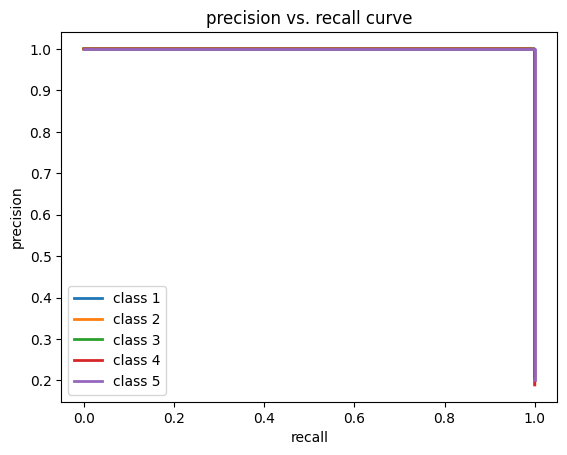

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

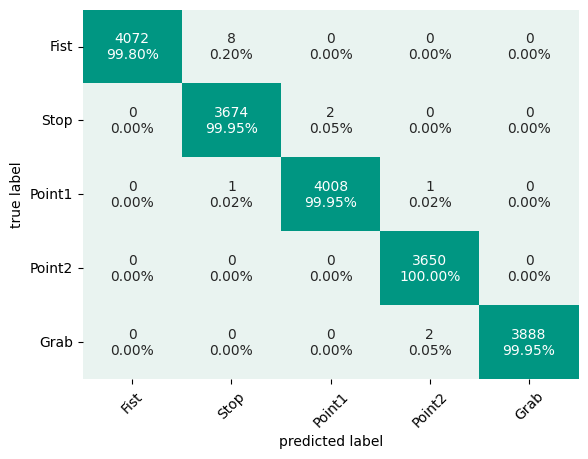

In [150]:
mixed_data_report = Report('rfc_mixed', RFC_demo, X_test_mixed, y_test_mixed, description=['mixed_data', 'raw features'])
print(mixed_data_report)
precision_recall_multiclass(RFC_demo, X_test_mixed, y_test_mixed)
y_pred_mixed = RFC_demo.predict(X_test_mixed)
plot_cm(y_test_mixed, y_pred_mixed)

Too good to be true...<br>
This was a demonstration how we should not split the data set!
Many people on kaggel etc. made this mistake

From now on we will not use this (wrong) processed data set

### b) Custom CV - with raw data

In [151]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    # Create the classifier
    RFC_split_raw = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state)

    X_train_split_raw, y_train_split_raw, X_test_split_raw, y_test_split_raw, user_list = custom_cv_approach(df_raw, user_list, num_user_test=num_user_test)
    
    # Normalize the data
    scaler = MinMaxScaler()
    scaler.fit(X_train_split_raw)
    X_train_split_raw = scaler.transform(X_train_split_raw)
    X_test_split_raw = scaler.transform(X_test_split_raw)
    
    # Fit the model
    RFC_split_raw.fit(X_train_split_raw, y_train_split_raw)
    model_acc = RFC_split_raw.score(X_test_split_raw, y_test_split_raw)

    # Print the results
    print('Train accuracy: ', RFC_split_raw.score(X_train_split_raw, y_train_split_raw))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = RFC_split_raw
        best_acc = model_acc
        X_test_best = X_test_split_raw
        y_test_best = y_test_split_raw


**************************************************
CV Run: 0
User picked for test set: 9, 8
train_indices examples: 66493
test_indices examples: 10731
Train accuracy:  1.0
(CV-) Test accuracy:  0.7893952101388501
**************************************************
CV Run: 1
User picked for test set: 10, 2
train_indices examples: 52407
test_indices examples: 14086
Train accuracy:  1.0
(CV-) Test accuracy:  0.742439301434048
**************************************************
CV Run: 2
User picked for test set: 12, 14
train_indices examples: 40047
test_indices examples: 12360
Train accuracy:  1.0
(CV-) Test accuracy:  0.6821197411003236
**************************************************
CV Run: 3
User picked for test set: 13, 11
train_indices examples: 23247
test_indices examples: 16800
Train accuracy:  1.0
(CV-) Test accuracy:  0.7125


#### Evaluation

/tmp/ipykernel_25124/286439724.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 's

(10731, 5)
(10731,)
(10731,)
27760    1
27761    1
27762    1
27763    1
27764    1
        ..
38486    5
38487    5
38488    5
38489    5
38490    5
Name: Class, Length: 10731, dtype: int64

        ***********************REPORT*******************************
        Average (macro) precision: 0.80321
        Average accuracy: 0.789395
        Average (macro) recall: 0.798657
        Average (macro) f1-score: 0.789222
        Description cv_data, raw features
        ************************************************************
        


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

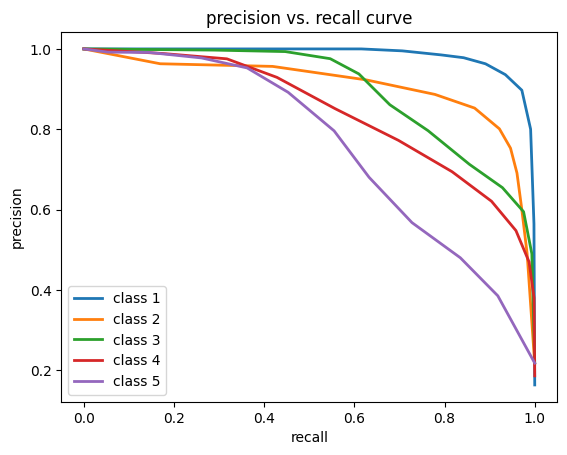

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

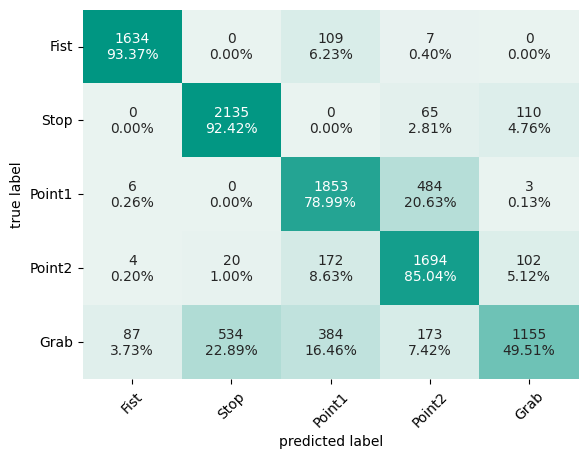

In [152]:
raw_w_cv_data_report = Report('rfc_raw', best_model, X_test_best, y_test_best, description=['cv_data', 'raw features'])
df_results = raw_w_cv_data_report.get_report_as_df(df_results)
print(raw_w_cv_data_report)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred_split_raw = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred_split_raw)

Here we can see that its difficult for the model to classify the "Fist" and "Point2" data points

### c) Custom CV - with extracted features

In [153]:
# From now on we will use the following data
df_aggregate

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3,User,Class
0,31.220158,27.403799,-33.548944,5.0,-0.592168,-0.526425,0.610093,-0.679408,-0.080937,-0.729283,-0.433292,0.846361,0.309729,3303.459708,31.125729,393.299191,0,1
1,32.392560,27.823996,-32.104566,5.0,-0.612694,-0.533061,0.583483,-0.660054,-0.060910,-0.748745,-0.434667,0.843882,0.314529,3308.347956,26.851403,393.193165,0,1
2,32.081207,27.936918,-32.385520,5.0,-0.606186,-0.535279,0.588231,-0.658320,-0.077302,-0.748758,-0.446266,0.841131,0.305525,3313.095350,27.067267,395.055695,0,1
3,31.719552,27.575915,-32.964177,5.0,-0.600247,-0.529105,0.599793,-0.655695,-0.103896,-0.747843,-0.458004,0.842172,0.284569,3306.145497,27.729013,393.524673,0,1
4,31.594851,27.416170,-33.195235,5.0,-0.598431,-0.526505,0.603881,-0.657469,-0.108005,-0.745701,-0.457837,0.843284,0.281527,3304.675159,29.444009,393.498111,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,27.823671,97.288106,-29.054040,10.0,0.875153,-0.440633,-0.199875,-0.449442,-0.893308,0.001453,0.179191,-0.088561,0.979820,2029.730672,761.522468,584.641706,14,5
77220,28.021968,97.191781,-29.248339,10.0,0.869813,-0.446504,-0.209904,-0.461688,-0.886626,-0.027154,0.173982,-0.120529,0.977345,2064.006800,762.311322,588.108972,14,5
77221,28.103645,96.953570,-29.735080,10.0,0.865906,-0.452405,-0.213392,-0.472325,-0.879944,-0.051069,0.164669,-0.145012,0.975631,2074.594214,767.103862,592.169837,14,5
77222,20.384035,93.649845,-25.356364,9.0,0.213676,0.226960,0.950174,-0.815051,0.577614,0.045320,0.538548,0.784124,-0.308407,591.537322,1397.531289,1796.343364,14,5


In [154]:
def cv_ratio(y_test, df):
    print(f'Ratio of test set: {len(y_test)/len(df)}')

In [155]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    RFC_cv_extract = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state)

    # Split the data
    X_train_cv_extract, y_train_cv_extract, X_test_cv_extract, y_test_cv_extract, user_list = custom_cv_approach(df_aggregate, user_list, num_user_test=num_user_test)
    cv_ratio(y_test_cv_extract, df_aggregate)
    print(X_train_cv_extract.columns.tolist())

    # Normalize the data
    scaler = MinMaxScaler()
    scaler.fit(X_train_cv_extract)
    X_train_cv_extract = scaler.transform(X_train_cv_extract)
    X_test_cv_extract = scaler.transform(X_test_cv_extract)

    # Fit the model
    RFC_cv_extract.fit(X_train_cv_extract, y_train_cv_extract)
    model_acc = RFC_cv_extract.score(X_test_cv_extract, y_test_cv_extract)
    
    # Print the results
    print('Train accuracy: ', RFC_cv_extract.score(X_train_cv_extract, y_train_cv_extract))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = RFC_cv_extract
        best_acc = model_acc
        X_test_best = X_test_cv_extract
        y_test_best = y_test_cv_extract


**************************************************
CV Run: 0
User picked for test set: 1, 2
train_indices examples: 67994
test_indices examples: 9230
Ratio of test set: 0.11952242826064435
['X_mean', 'Y_mean', 'Z_mean', 'n_points', 'eigenvec_1_1', 'eigenvec_1_2', 'eigenvec_1_3', 'eigenvec_2_1', 'eigenvec_2_2', 'eigenvec_2_3', 'eigenvec_3_1', 'eigenvec_3_2', 'eigenvec_3_3', 'eigenval_1', 'eigenval_2', 'eigenval_3']
Train accuracy:  1.0
(CV-) Test accuracy:  0.7641386782231853
**************************************************
CV Run: 1
User picked for test set: 8, 13
train_indices examples: 52444
test_indices examples: 15550
Ratio of test set: 0.20136227079664354
['X_mean', 'Y_mean', 'Z_mean', 'n_points', 'eigenvec_1_1', 'eigenvec_1_2', 'eigenvec_1_3', 'eigenvec_2_1', 'eigenvec_2_2', 'eigenvec_2_3', 'eigenvec_3_1', 'eigenvec_3_2', 'eigenvec_3_3', 'eigenval_1', 'eigenval_2', 'eigenval_3']
Train accuracy:  1.0
(CV-) Test accuracy:  0.905144694533762
***************************************

#### Evaluation

/tmp/ipykernel_25124/286439724.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 's

(15550, 5)
(15550,)
(15550,)
27760    1
27761    1
27762    1
27763    1
27764    1
        ..
69724    5
69725    5
69726    5
69727    5
69728    5
Name: Class, Length: 15550, dtype: int64

        ***********************REPORT*******************************
        Average (macro) precision: 0.91421
        Average accuracy: 0.905145
        Average (macro) recall: 0.905503
        Average (macro) f1-score: 0.90734
        Description cv_data, extracted features
        ************************************************************
        


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

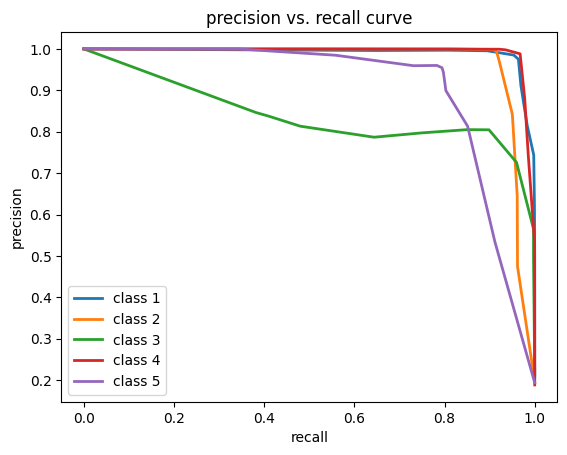

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

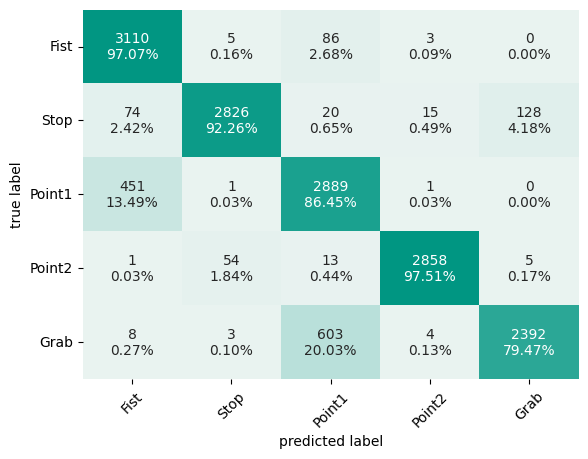

In [156]:
extract_w_cv_data_report = Report('rfc_extract', best_model, X_test_best, y_test_best, description=['cv_data', 'extracted features'])
df_results = extract_w_cv_data_report.get_report_as_df(df_results)
print(extract_w_cv_data_report)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred_cv_extract = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred_cv_extract)

With the extracted features the model improved in predicting "Point2" data points, but the perfomance for predicting "Grab" decreased

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

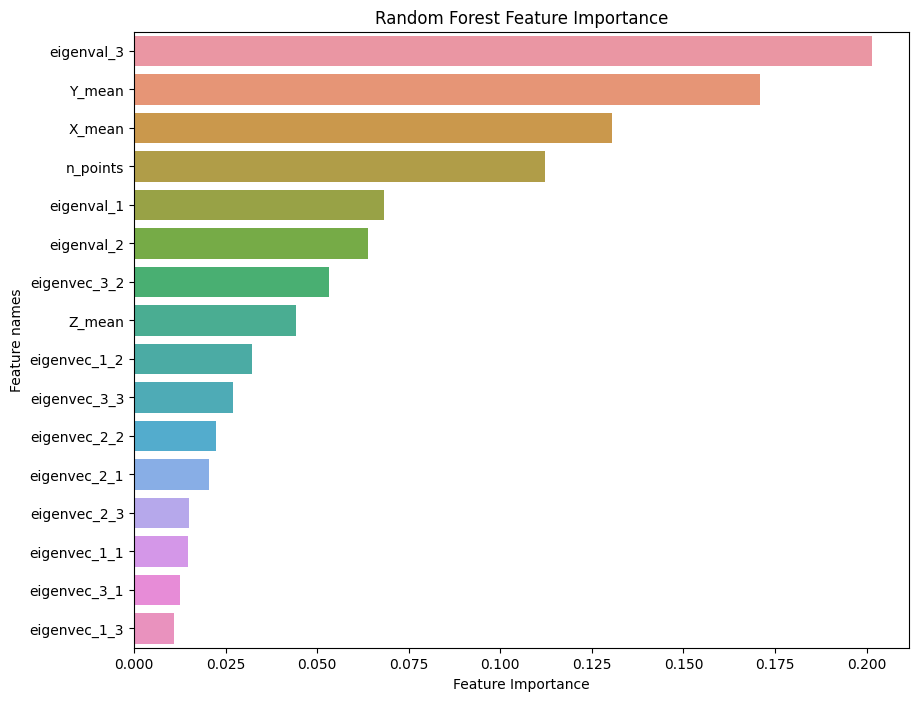

In [157]:
feature_list = df_aggregate.columns.to_list()
feature_list.remove('User')
feature_list.remove('Class')
plot_feature_importance_rf(best_model, feature_list)

## Logistic Regression

In [158]:
# Hyperparameters:
penalty = 'l2'
C = 1.0 #regularization strength. The smaller the value, the stronger the regularization.
random_state = 2023
solver = 'lbfgs' # One of the possible solver for multiclass problems (‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’)
max_iter = 300


### a) Custom CV - with raw data

In [159]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    logReg_split_raw = LogisticRegression(penalty=penalty, C=C,random_state=random_state, solver=solver, max_iter=max_iter)

    X_train_split_raw, y_train_split_raw, X_test_split_raw, y_test_split_raw, user_list = custom_cv_approach(df_raw, user_list, num_user_test=num_user_test)
    
    # Scale the data
    scaler = StandardScaler()
    scaler.fit(X_train_split_raw)
    X_train_split_raw = scaler.transform(X_train_split_raw)
    X_test_split_raw = scaler.transform(X_test_split_raw)
    
    # Fit the model
    logReg_split_raw.fit(X_train_split_raw, y_train_split_raw)
    model_acc = logReg_split_raw.score(X_test_split_raw, y_test_split_raw)

    # Print the results
    print('Train accuracy: ', logReg_split_raw.score(X_train_split_raw, y_train_split_raw))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = logReg_split_raw
        best_acc = model_acc
        X_test_best = X_test_split_raw
        y_test_best = y_test_split_raw


**************************************************
CV Run: 0
User picked for test set: 12, 10
train_indices examples: 62786
test_indices examples: 14438
Train accuracy:  0.8494409581753894
(CV-) Test accuracy:  0.8207507965092118
**************************************************
CV Run: 1
User picked for test set: 8, 14
train_indices examples: 48480
test_indices examples: 14306


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.8660891089108911
(CV-) Test accuracy:  0.7261987977072557
**************************************************
CV Run: 2
User picked for test set: 6, 9
train_indices examples: 40183
test_indices examples: 8297


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.8646940248363736
(CV-) Test accuracy:  0.7208629625165722
**************************************************
CV Run: 3
User picked for test set: 0, 5
train_indices examples: 26030
test_indices examples: 14153
Train accuracy:  0.9286976565501345
(CV-) Test accuracy:  0.5192538684377871


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Error occured:
ConvergenceWarning: lbfgs failed to converge (status=1)
-> increase max_iter

#### Evaluation

/tmp/ipykernel_25124/286439724.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 's

(14438, 5)
(14438,)
(14438,)
38491    1
38492    1
38493    1
38494    1
38495    1
        ..
60985    5
60986    5
60987    5
60988    5
60989    5
Name: Class, Length: 14438, dtype: int64

        ***********************REPORT*******************************
        Average (macro) precision: 0.85654
        Average accuracy: 0.820751
        Average (macro) recall: 0.822673
        Average (macro) f1-score: 0.822449
        Description LogReg, cv_data, raw features
        ************************************************************
        


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

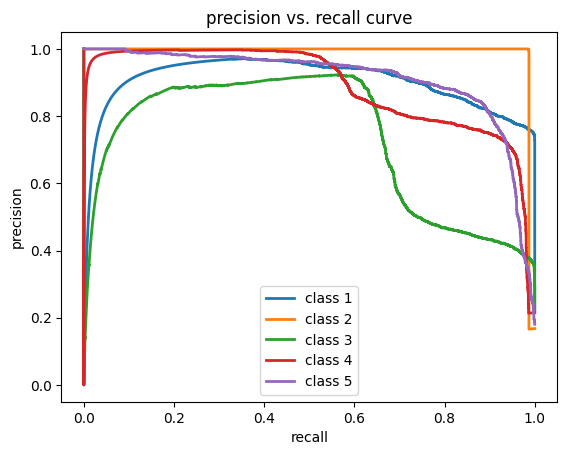

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

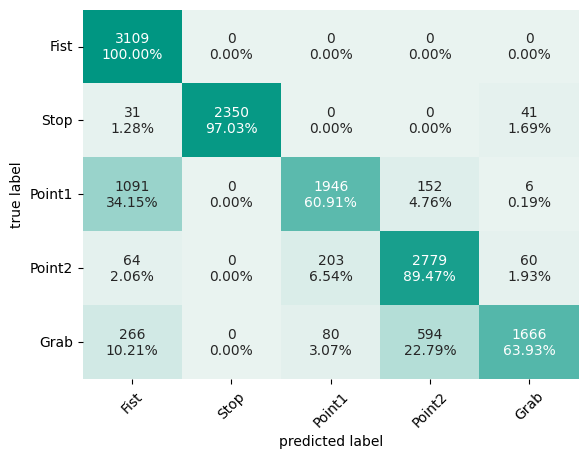

In [160]:
raw_w_cv_data_report_lg = Report('lg_raw', best_model, X_test_best, y_test_best, description=['LogReg', 'cv_data', 'raw features'])
df_results = raw_w_cv_data_report_lg.get_report_as_df(df_results)
print(raw_w_cv_data_report_lg)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

### b) Custom CV - with extracted features

In [161]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    logReg_split_raw = LogisticRegression(penalty=penalty, C=C,random_state=random_state, solver=solver)

    # Split the data
    X_train_cv_extract, y_train_cv_extract, X_test_cv_extract, y_test_cv_extract, user_list = custom_cv_approach(df_aggregate, user_list, num_user_test=num_user_test)
    cv_ratio(y_test_cv_extract, df_aggregate)

    # Normalize the data
    scaler = MinMaxScaler()
    scaler.fit(X_train_cv_extract)
    X_train_cv_extract = scaler.transform(X_train_cv_extract)
    X_test_cv_extract = scaler.transform(X_test_cv_extract)

    # Fit the model
    logReg_split_raw.fit(X_train_cv_extract, y_train_cv_extract)
    model_acc = logReg_split_raw.score(X_test_cv_extract, y_test_cv_extract)
    
    # Print the results
    print('Train accuracy: ', logReg_split_raw.score(X_train_cv_extract, y_train_cv_extract))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = logReg_split_raw
        best_acc = model_acc
        X_test_best = X_test_cv_extract
        y_test_best = y_test_cv_extract


**************************************************
CV Run: 0
User picked for test set: 1, 8
train_indices examples: 65696
test_indices examples: 11528
Ratio of test set: 0.149280016575158


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.9182750852411106
(CV-) Test accuracy:  0.7198993754337266
**************************************************
CV Run: 1
User picked for test set: 2, 6
train_indices examples: 56806
test_indices examples: 8890
Ratio of test set: 0.11511965192168237


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.9432806393690807
(CV-) Test accuracy:  0.7038245219347582
**************************************************
CV Run: 2
User picked for test set: 5, 0
train_indices examples: 42653
test_indices examples: 14153
Ratio of test set: 0.18327203978037915


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.9632147797341336
(CV-) Test accuracy:  0.6231187734049318
**************************************************
CV Run: 3
User picked for test set: 12, 14
train_indices examples: 30293
test_indices examples: 12360
Ratio of test set: 0.16005386926344142
Train accuracy:  0.9833294820585614
(CV-) Test accuracy:  0.704368932038835


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Evaluation

/tmp/ipykernel_25124/286439724.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 's

(11528, 5)
(11528,)
(11528,)
9048     1
9049     1
9050     1
9051     1
9052     1
        ..
34566    5
34567    5
34568    5
34569    5
34570    5
Name: Class, Length: 11528, dtype: int64

        ***********************REPORT*******************************
        Average (macro) precision: 0.71716
        Average accuracy: 0.719899
        Average (macro) recall: 0.731548
        Average (macro) f1-score: 0.714417
        Description LogReg, cv_data, extracted features
        ************************************************************
        


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

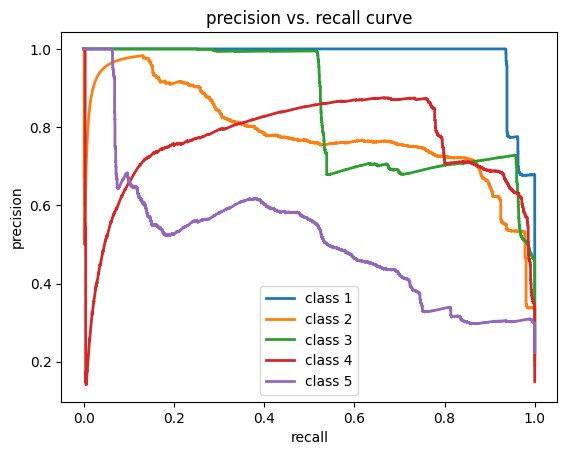

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

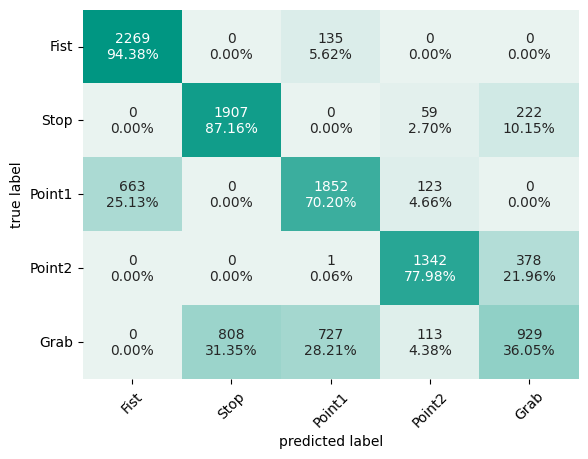

In [162]:
extract_w_cv_data_report_lg = Report('lg_extract', best_model, X_test_best, y_test_best, description=['LogReg', 'cv_data', 'extracted features'])
df_results = extract_w_cv_data_report_lg.get_report_as_df(df_results)
print(extract_w_cv_data_report_lg)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

## Support Vector Machine (SVM)

### a) Custom CV - with raw data

In [163]:
# Hyperparameters:
penalty = 'l2'
C = 1.0 #regularization strength. The smaller the value, the stronger the regularization.
gamma='scale'
kernel = 'rbf'
decision_function_shape = 'ovo'
random_state = 2023
max_iter = -1 # -1 means no limit
cache_size = 200 # in MB
probabilty = True # needed for predict_proba later on


In [164]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    svm_model_split_raw = SVC(decision_function_shape=decision_function_shape, kernel=kernel, C=C, gamma=gamma, max_iter=max_iter, cache_size=200, probability=probabilty)

    X_train_split_raw, y_train_split_raw, X_test_split_raw, y_test_split_raw, user_list = custom_cv_approach(df_raw, user_list, num_user_test=num_user_test)
    
    # Scale the data
    scaler = StandardScaler()
    scaler.fit(X_train_split_raw)
    X_train_split_raw = scaler.transform(X_train_split_raw)
    X_test_split_raw = scaler.transform(X_test_split_raw)
    
    # Fit the model
    svm_model_split_raw.fit(X_train_split_raw, y_train_split_raw)
    model_acc = svm_model_split_raw.score(X_test_split_raw, y_test_split_raw)

    # Print the results
    print('Train accuracy: ', svm_model_split_raw.score(X_train_split_raw, y_train_split_raw))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = svm_model_split_raw
        best_acc = model_acc
        X_test_best = X_test_split_raw
        y_test_best = y_test_split_raw

    


**************************************************
CV Run: 0
User picked for test set: 0, 13
train_indices examples: 59437
test_indices examples: 17787
Train accuracy:  0.9931019398691051
(CV-) Test accuracy:  0.8519705402822286
**************************************************
CV Run: 1
User picked for test set: 2, 8
train_indices examples: 48113
test_indices examples: 11324
Train accuracy:  0.9944297798931682
(CV-) Test accuracy:  0.7771105616389968
**************************************************
CV Run: 2
User picked for test set: 12, 6
train_indices examples: 38871
test_indices examples: 9242
Train accuracy:  0.9945975148568341
(CV-) Test accuracy:  0.767582774291279
**************************************************
CV Run: 3
User picked for test set: 11, 9
train_indices examples: 26890
test_indices examples: 11981
Train accuracy:  0.9948307921160283
(CV-) Test accuracy:  0.6989399883148318


#### Evaluation

(17787, 5)
(17787,)
(17787,)
0        1
1        1
2        1
3        1
4        1
        ..
69724    5
69725    5
69726    5
69727    5
69728    5
Name: Class, Length: 17787, dtype: int64

        ***********************REPORT*******************************
        Average (macro) precision: 0.86518
        Average accuracy: 0.851971
        Average (macro) recall: 0.848534
        Average (macro) f1-score: 0.849984
        Description SVM, cv_data, raw features
        ************************************************************
        


/tmp/ipykernel_25124/286439724.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 's

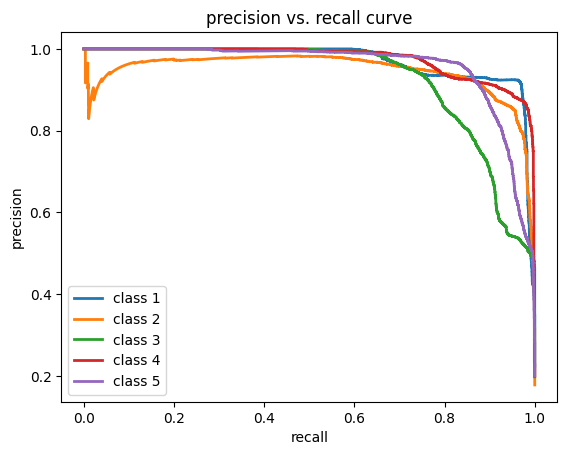

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

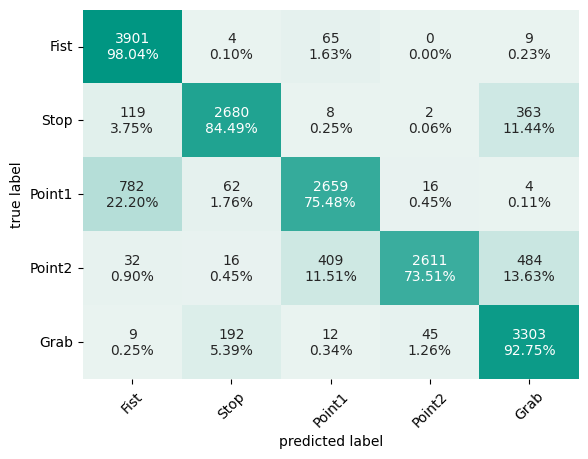

In [165]:
raw_w_cv_data_report_svm = Report('svm_raw', best_model, X_test_best, y_test_best, description=['SVM', 'cv_data', 'raw features'])
df_results = raw_w_cv_data_report_svm.get_report_as_df(df_results)
print(raw_w_cv_data_report_svm)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

### b) Custom CV - with extracted features

In [166]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    svm_model_split_extract = SVC(decision_function_shape=decision_function_shape, kernel=kernel, C=C, gamma=gamma, max_iter=max_iter, cache_size=200, probability=probabilty)

    # Split the data
    X_train_cv_extract, y_train_cv_extract, X_test_cv_extract, y_test_cv_extract, user_list = custom_cv_approach(df_aggregate, user_list, num_user_test=num_user_test)
    cv_ratio(y_test_cv_extract, df_aggregate)

    # Normalize the data
    scaler = MinMaxScaler()
    scaler.fit(X_train_cv_extract)
    X_train_cv_extract = scaler.transform(X_train_cv_extract)
    X_test_cv_extract = scaler.transform(X_test_cv_extract)

    # Fit the model
    svm_model_split_extract.fit(X_train_cv_extract, y_train_cv_extract)
    model_acc = svm_model_split_extract.score(X_test_cv_extract, y_test_cv_extract)
    
    # Print the results
    print('Train accuracy: ', svm_model_split_extract.score(X_train_cv_extract, y_train_cv_extract))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = svm_model_split_extract
        best_acc = model_acc
        X_test_best = X_test_cv_extract
        y_test_best = y_test_cv_extract


**************************************************
CV Run: 0
User picked for test set: 8, 1
train_indices examples: 65696
test_indices examples: 11528
Ratio of test set: 0.149280016575158
Train accuracy:  0.994626765708719
(CV-) Test accuracy:  0.8223455933379598
**************************************************
CV Run: 1
User picked for test set: 9, 11
train_indices examples: 53715
test_indices examples: 11981
Ratio of test set: 0.15514606857971616
Train accuracy:  0.9951410220608768
(CV-) Test accuracy:  0.9273850262916284
**************************************************
CV Run: 2
User picked for test set: 13, 14
train_indices examples: 37481
test_indices examples: 16234
Ratio of test set: 0.21021962084326115
Train accuracy:  0.9983991889223873
(CV-) Test accuracy:  0.7991868917087593
**************************************************
CV Run: 3
User picked for test set: 6, 5
train_indices examples: 27999
test_indices examples: 9482
Ratio of test set: 0.12278566248834559
Train accu

#### Evaluation

(11981, 5)
(11981,)
(11981,)
34571    1
34572    1
34573    1
34574    1
34575    1
        ..
56120    5
56121    5
56122    5
56123    5
56124    5
Name: Class, Length: 11981, dtype: int64

        ***********************REPORT*******************************
        Average (macro) precision: 0.9405
        Average accuracy: 0.927385
        Average (macro) recall: 0.930362
        Average (macro) f1-score: 0.929365
        Description SVM, cv_data, extracted features
        ************************************************************
        


/tmp/ipykernel_25124/286439724.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 's

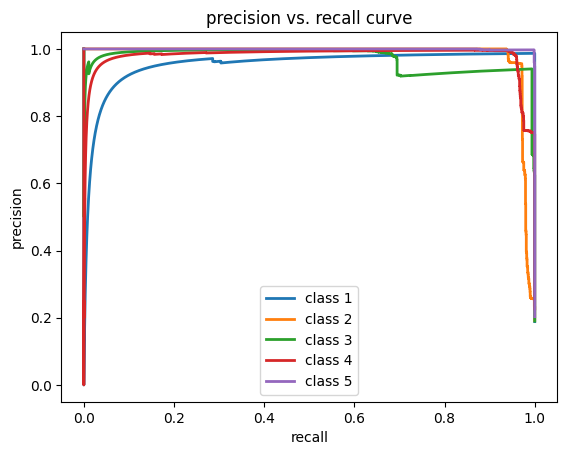

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

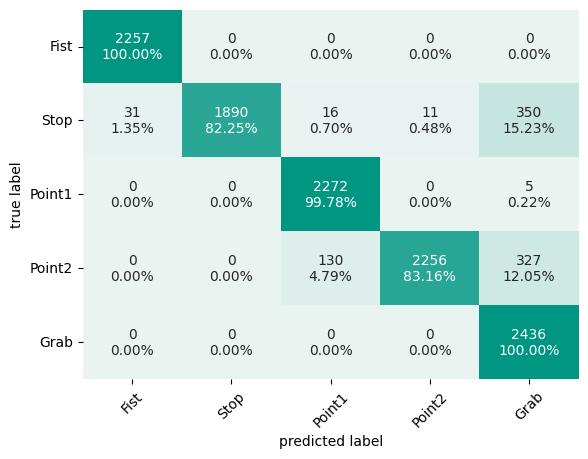

In [167]:
extract_w_cv_data_report_svm = Report('svm_extract', best_model, X_test_best, y_test_best, description=['SVM', 'cv_data', 'extracted features'])
df_results = extract_w_cv_data_report_svm.get_report_as_df(df_results)
print(extract_w_cv_data_report_svm)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

TODO other models to try <br>
LightGBM

In [168]:
#TODO boxplot of the results
'''
ax = sns.boxplot(data = f2_df, linewidth=1, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.set(rc = {'figure.figsize':(8,10)})
ax.set(ylabel='F2-Score')
ax.set_title('F2-Score Deviation of different Models')
'''

"\nax = sns.boxplot(data = f2_df, linewidth=1, showfliers=False)\nax.set_xticklabels(ax.get_xticklabels(),rotation=90)\nsns.set(rc = {'figure.figsize':(8,10)})\nax.set(ylabel='F2-Score')\nax.set_title('F2-Score Deviation of different Models')\n"

## Conclusion Testing Phase I

TODO

Extracted features?
* good, we see an improvement ...

Confusion Matrix:
* what cases are difficult
* which are easy
* explanation why

Feature reduction
* good/bad
* PCA
* which models got worses

Best model:
* e.g. rf with extracted data

# 4. Testing Phase II: Model Develepoment

## Base MLP structure

* Activation Functions
    - output layer: one neuron for each class (5)
    - we want the the probability of the each class, -> **softmax**
    - hidden Layer: start with **ReLU**

* Optimizer
    - **rmsprop**

* loss
    - **categorical_crossentropy**

* Hidden Layers and Number of Neurons
    - start with small architecture, increase size

* Metric
    - **accuracy**
    - **precission**


In [179]:
# Hyperparameters
#TODO set number of epochs to 15
#TODO 45 per k fold (4 folds) will take 5 hours #40 is fine # 35 is fine
hyperparams = {'num_epochs': 1,
               'batch_size':10,
               'hidden_layer':2,
               'units_hidden_layer': 32,
               'activation_hidden': 'relu',
               'activation_output': 'softmax',
               'loss': 'categorical_crossentropy',
               'metrics': ['categorical_accuracy', 'Precision', tf.keras.metrics.Recall()],
               'optimizer': keras.optimizers.legacy.Adam(),
               'initialization': '-',
               'weight regularisation l2': '-',
               'dropout': '-',  # typically between 0.3 and 0.5 (half of weights get 0)
               'early Stopping': 'False'} 

In [180]:
from tensorflow import keras
from tensorflow.keras import layers


def build_mlp_model(name:str, hyperparams:dict, input_shape: tuple, output_shape: int) -> keras.Sequential:
    'Build MLP classification network'

    model = keras.Sequential(name=name)
    model.add(keras.Input(shape=input_shape))
    model.add(layers.Dense(32, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(16, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(output_shape, activation='softmax'))

    model.compile(optimizer=hyperparams['optimizer'], loss=hyperparams['loss'], metrics=hyperparams['metrics'])

    return model

In [181]:
def plot_learning_curves(hist, parameters, name:str):
    
    plt.plot(hist['epoch'][:],hist['loss'][:], "k--", linewidth=1.5, label="Training")
    plt.plot(hist['epoch'][:],hist['val_loss'][:], "b-.", linewidth=1.5, label="CV test")
    plt.legend()
    plt.ylim(0,max(hist['loss'][:].max(), hist['val_loss'][:].max())+0.2)
    plt.xlabel("Epochs"),  plt.ylabel("categorical_crossentropy")

    plt.title(f'Learning Curve: {name}', fontsize=18)
    plt.show()

In [182]:
def save_history(hist, name):

    # Get path to save the history
    hist_folder = 'model/single_run/history'
    model_path = join(hist_folder, name)
    
    with open(model_path, 'wb') as file_pi:
        pickle.dump(hist, file_pi)

def load_history(name):

    # Get path to save the history
    hist_folder = 'model/single_run/history'
    model_path = join(hist_folder, name)
    
    with open(model_path, 'rb') as file_pi:
        history = pickle.load(file_pi)
    
    return history

In [183]:
def save_eval_dict_pkl(eval_dict, name):

    # Get path to save the history
    eval_folder = 'model/single_run/eval'
    model_path = join(eval_folder, name)
    
    with open(model_path, 'wb') as file_pi:
        pickle.dump(eval_dict, file_pi)

def load_eval_dict_pkl(name) -> dict:

    # Get path to save the history
    eval_folder = 'model/single_run/eval'
    model_path = join(eval_folder, name)

    with open(model_path, 'rb') as file_pi:
        eval_dict = pickle.load(file_pi)
    
    return eval_dict

def save_to_eval_dict(eval_dict:dict, split_set:str, acc:float, precission:float, recall:float, f1:float):
    ''' Save multiple metrics to a dictionary for evaluation '''

    if split_set not in ['train', 'test']:
        raise ValueError('split_set must be either train or test')
    
    eval_dict[split_set]['accuracy'].append(acc)
    eval_dict[split_set]['precision'].append(precission)
    eval_dict[split_set]['recall'].append(recall)
    eval_dict[split_set]['f1'].append(f1)

    return eval_dict

In [184]:
def list_used_parameters(parameters:dict):
    print('Used parameters:')
    for parameter, value in parameters.items():
        print(f'{parameter}: {value}')

In [185]:
def decode_one_hot(one_hot_encoded):
    return np.argmax(one_hot_encoded)

In [186]:
def calc_f1_score_mlp(model, X, y):
    # Calculate f1 score of mlp
    y_pred1 = model.predict(X)
    y_pred = np.argmax(y_pred1, axis=1)

    # to one hot encoding
    y_pred = to_categorical(y_pred)


    return f1_score(y, y_pred , average="macro")

In [189]:
def train_k_mlp_model(name, df:pd.DataFrame, hyperparams:dict):
    '''
    Train a MLP model with k-fold cross validation (leave n users out strategy)

    Parameters
    ----------
    name : str, Name of the model.

    Returns
    ----------
    best_model : keras.Sequential, The best model.
    best_acc : float, The best accuracy.
    X_test_best : numpy.ndarray, The best test set.
    y_test_best : numpy.ndarray, The best test set.
    '''
    

    # Create a list of users
    user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

    # Number of users to be used for the test set
    num_user_test = 2
    num_of_iterations = 4

    best_model = None
    best_acc = 0
    X_test_best = None
    y_test_best = None

    all_acc_val = []
    all_prec_val = []

    # Evaluation dict
    #TODO add recall and f1 score
    eval_dict = {'train': {'accuracy':[], 'precision':[], 'recall':[], 'f1': []},
                 'test': {'accuracy':[], 'precision':[], 'recall':[], 'f1': []}}

    describe_model = True

    for i in range(num_of_iterations):

        print('*'*50)
        print(f'CV Run: {i}')

        # Split the data
        X_train_cv_extract, y_train_cv_extract, X_test_cv_extract, y_test_cv_extract, user_list = custom_cv_approach(df, user_list, num_user_test=num_user_test)
        cv_ratio(y_test_cv_extract, df)

        # Normalize the data
        scaler = MinMaxScaler()
        scaler.fit(X_train_cv_extract)
        X_train_cv_extract = scaler.transform(X_train_cv_extract)
        X_test_cv_extract = scaler.transform(X_test_cv_extract)
        # y label to one hot encode
        y_train_cv_extract = to_categorical(y_train_cv_extract)
        y_test_cv_extract = to_categorical(y_test_cv_extract)

        # Build the model
        # TODO
        mlp_model = build_mlp_model(name, hyperparams, input_shape=X_train_cv_extract.shape[1:], output_shape=y_train_cv_extract.shape[1])

        # Only print the model summary once
        if describe_model:
            mlp_model.summary()
            describe_model = False

        # Create callback
        # Use early stopping later because it is a form of regularization
        #early_stop_callback = keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", min_delta=1e-4, patience=5, verbose=1)
        checkpoint_callback = keras.callbacks.ModelCheckpoint(f'model/single_run/{name}_cv{i}.h5', save_best_only=True)

        # Train the model
        history = mlp_model.fit(X_train_cv_extract, 
                                y_train_cv_extract, 
                                epochs=hyperparams['num_epochs'], 
                                batch_size= hyperparams['batch_size'],
                                validation_data=(X_test_cv_extract, y_test_cv_extract),
                                verbose=0,
                                shuffle=True,
                                callbacks=[checkpoint_callback])

        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        # Save the history
        save_history(hist, f'{name}_cv{i}')

        #Evaluating the training performance:
        train_loss, train_acc, train_precision, train_recall = mlp_model.evaluate(x=X_train_cv_extract, y=y_train_cv_extract, batch_size=hyperparams['batch_size'], verbose=3)
        f1_score_train = calc_f1_score_mlp(mlp_model, X_train_cv_extract, y_train_cv_extract)

        eval_dict = save_to_eval_dict(eval_dict, 'train', train_acc, train_precision, train_recall, f1_score_train)
        print('-'*70)
        print('Evaluation of training Data: \n', 'training loss: ', train_loss, 'training accuracy: ', train_acc)

        #Evaluating the CV pperformance:
        val_loss, val_acc, val_precision, val_recall = mlp_model.evaluate(x=X_test_cv_extract, y=y_test_cv_extract, batch_size=hyperparams['batch_size'], verbose=0)
        f1_score_test = calc_f1_score_mlp(mlp_model, X_test_cv_extract, y_test_cv_extract)
        eval_dict = save_to_eval_dict(eval_dict, 'test', val_acc, val_precision, val_recall, f1_score_test)
        all_acc_val.append(val_acc)
        all_prec_val.append(val_precision)
        print('Evaluation of validation Data: \n', 'cv loss: ', val_loss, 'cv accuracy: ', val_acc)

        # Save best model
        if model_acc > best_acc:
            best_model = mlp_model
            best_acc = model_acc
            X_test_best = X_test_cv_extract
            y_test_best = y_test_cv_extract

    #Lets see the overall score as average of the scores of all the folds:
    print('-'*70)
    print('(all CV runs combined)')
    print('Mean Accuracy  for the validation dataset: ', np.mean(all_acc_val))
    print('Mean Precision for the validation dataset: ', np.mean(all_prec_val))
    print('-'*70)

    # Save the model
    best_model.save(f'model/single_run/{name}_best_model.h5')

    # Save the evaluation dict
    save_eval_dict_pkl(eval_dict, f'{name}_eval_dict')

    # Plot the learning curves
    plot_learning_curves(hist, hyperparams, name)

    return best_model, best_acc, X_test_best, y_test_best, eval_dict


### a) Custom CV - with raw data

To get an Idea How long the model trains: <br>
13 min 30 sec for 4 runs
* each trains for 2 epochs

Highly depends on the used Hardware! <br>
Here we use an M1 macbook with GPU tf vesion

**************************************************
CV Run: 0
User picked for test set: 11, 13
train_indices examples: 60424
test_indices examples: 16800
Ratio of test set: 0.21754894851341552
Model: "mlp_base_model_raw"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 32)                992       
                                                                 
 dense_50 (Dense)            (None, 64)                2112      
                                                                 
 dense_51 (Dense)            (None, 16)                1040      
                                                                 
 dense_52 (Dense)            (None, 6)                 102       
                                                                 
Total params: 4,246
Trainable params: 4,246
Non-trainable params: 0
____________________________________________________

/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


----------------------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.45391544699668884 training accuracy:  0.8374321460723877
525/525 [==============================] - 1s 1ms/step


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Evaluation of validation Data: 
 cv loss:  0.6045350432395935 cv accuracy:  0.7650595307350159
**************************************************
CV Run: 1
User picked for test set: 1, 9
train_indices examples: 51787
test_indices examples: 8637
Ratio of test set: 0.11184346835180772
1619/1619 [==============================] - 2s 929us/step


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


----------------------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.44922545552253723 training accuracy:  0.8455597162246704
270/270 [==============================] - 0s 931us/step
Evaluation of validation Data: 
 cv loss:  0.9881038665771484 cv accuracy:  0.5690633058547974
**************************************************
CV Run: 2
User picked for test set: 8, 5
train_indices examples: 39871
test_indices examples: 11916
Ratio of test set: 0.154304361338444


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1246/1246 [==============================] - 1s 952us/step


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


----------------------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.4749610424041748 training accuracy:  0.8504176139831543
373/373 [==============================] - 0s 933us/step
Evaluation of validation Data: 
 cv loss:  1.0623986721038818 cv accuracy:  0.5880329012870789
**************************************************
CV Run: 3
User picked for test set: 0, 6
train_indices examples: 26446
test_indices examples: 13425
Ratio of test set: 0.17384491867813115


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


827/827 [==============================] - 1s 975us/step


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


----------------------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.4259083867073059 training accuracy:  0.8485215306282043
420/420 [==============================] - 0s 940us/step
Evaluation of validation Data: 
 cv loss:  1.287350058555603 cv accuracy:  0.5134450793266296
----------------------------------------------------------------------
(all CV runs combined)
Mean Accuracy  for the validation dataset:  0.6089002043008804
Mean Precision for the validation dataset:  0.6262461990118027
----------------------------------------------------------------------


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 's

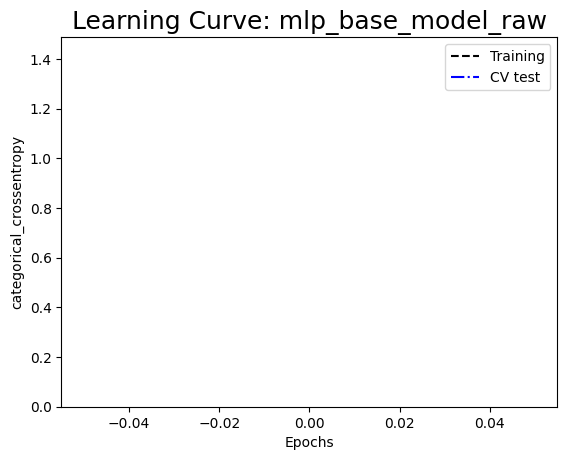

In [190]:
name = 'mlp_base_model_raw'
df = df_raw
best_model, best_acc, X_test_best, y_test_best, eval_dict = train_k_mlp_model(name, df, hyperparams)

In [191]:
#TODO write valid report function for mlp
#NEW COPY TO SERVER
# ALSO NEW save_history hist
##TODO add eval_dict to every model
'''
data_report_mlp_base_raw = Report('mlp_raw', best_model, X_test_best, y_test_best, description=['MLP base', 'cv_data', 'raw features'])
print(data_report_mlp_base_raw)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)

'''
print(eval_dict)
#plot_cm(y_test_best, y_pred)

{'train': {'accuracy': [0.8374321460723877, 0.8455597162246704, 0.8504176139831543, 0.8485215306282043], 'precision': [0.8520340323448181, 0.8653072714805603, 0.8738166689872742, 0.8630174398422241], 'recall': [0.816993236541748, 0.8227161169052124, 0.8149281144142151, 0.8340391516685486], 'f1': [0.6959757605317707, 0.7041027302878208, 0.7094004087810105, 0.6967453435199458]}, 'test': {'accuracy': [0.7650595307350159, 0.5690633058547974, 0.5880329012870789, 0.5134450793266296], 'precision': [0.8042569756507874, 0.5709555149078369, 0.6033664345741272, 0.5264058709144592], 'recall': [0.7444642782211304, 0.5589904189109802, 0.5655421018600464, 0.5041340589523315], 'f1': [0.6421904315576973, 0.458825746403223, 0.4896855511638443, 0.3816991107473882]}}


In [192]:
def boxplot_model_comparison(df_result:pd.DataFrame):
    ax = sns.boxplot(data = f2_df, linewidth=1, showfliers=False)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    sns.set(rc = {'figure.figsize':(8,10)})
    ax.set(ylabel='F2-Score')
    ax.set_title('F2-Score Deviation of different Models')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

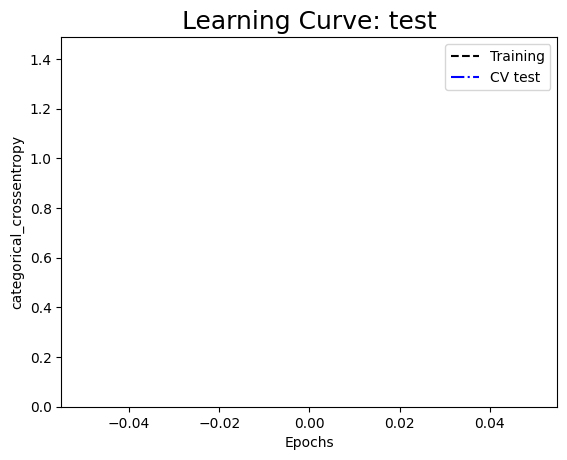

In [193]:
hist = load_history('mlp_base_model_raw_cv3')
plot_learning_curves(hist, hyperparams, 'test')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

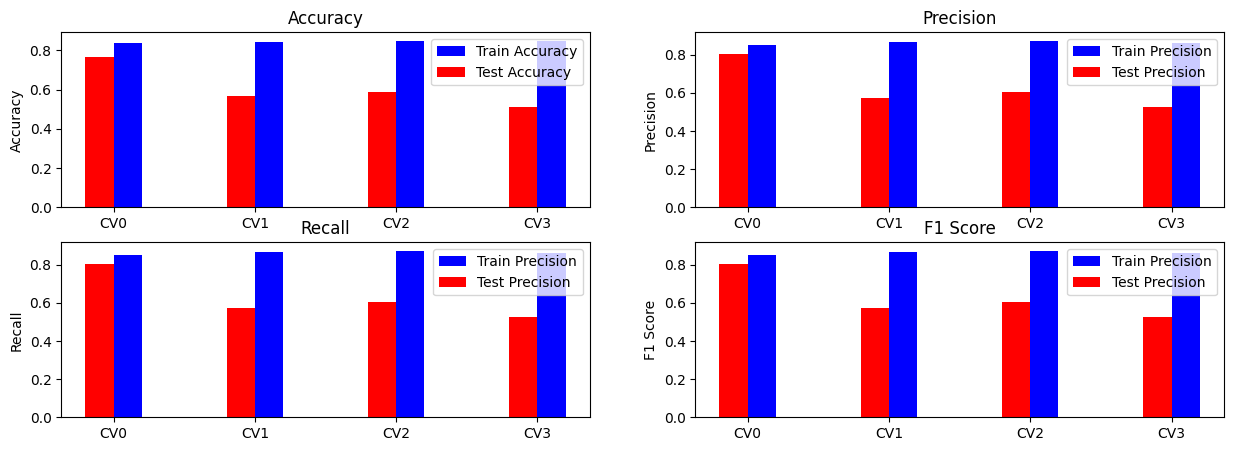

In [194]:
# Without training
eval_dict = load_eval_dict_pkl('mlp_base_model_raw_eval_dict')

def plot_eval_dict_barplot_new(data):

    # Extracting data
    train_acc = data['train']['accuracy']
    train_prec = data['train']['precision']
    test_acc = data['test']['accuracy']
    test_prec = data['test']['precision']

    # Creating subplots for accuracy and precision
    fig, axs = plt.subplots(2, 2, figsize=(15, 5))
    bar_width = 0.2

    # Plot for accuracy
    axs[0][0].bar([i+bar_width/2 for i in range(len(train_acc))], train_acc, width=bar_width, color='b', label='Train Accuracy')
    axs[0][0].bar([i-bar_width/2 for i in range(len(test_acc))], test_acc, width=bar_width, color='r', label='Test Accuracy')
    axs[0][0].set_xticks(range(len(train_acc)))
    axs[0][0].set_xticklabels([f'CV{i}' for i in range(len(train_acc))])
    axs[0][0].set_ylabel('Accuracy')
    axs[0][0].set_title('Accuracy')
    axs[0][0].legend()

    # Plot for precision
    axs[0][1].bar([i+bar_width/2 for i in range(len(train_prec))], train_prec, width=bar_width, color='b', label='Train Precision')
    axs[0][1].bar([i-bar_width/2 for i in range(len(test_prec))], test_prec, width=bar_width, color='r', label='Test Precision')
    axs[0][1].set_xticks(range(len(train_prec)))
    axs[0][1].set_xticklabels([f'CV{i}' for i in range(len(train_acc))])
    axs[0][1].set_ylabel('Precision')
    axs[0][1].set_title('Precision')
    axs[0][1].legend()

    # Plot for recall #TODO fix this
    axs[1][0].bar([i+bar_width/2 for i in range(len(train_prec))], train_prec, width=bar_width, color='b', label='Train Precision')
    axs[1][0].bar([i-bar_width/2 for i in range(len(test_prec))], test_prec, width=bar_width, color='r', label='Test Precision')
    axs[1][0].set_xticks(range(len(train_prec)))
    axs[1][0].set_xticklabels([f'CV{i}' for i in range(len(train_acc))])
    axs[1][0].set_ylabel('Recall')
    axs[1][0].set_title('Recall')
    axs[1][0].legend()

    # Plot for f1_score #TODO fix this
    axs[1][1].bar([i+bar_width/2 for i in range(len(train_prec))], train_prec, width=bar_width, color='b', label='Train Precision')
    axs[1][1].bar([i-bar_width/2 for i in range(len(test_prec))], test_prec, width=bar_width, color='r', label='Test Precision')
    axs[1][1].set_xticks(range(len(train_prec)))
    axs[1][1].set_xticklabels([f'CV{i}' for i in range(len(train_acc))])
    axs[1][1].set_ylabel('F1 Score')
    axs[1][1].set_title('F1 Score')
    axs[1][1].legend()

    plt.show()

plot_eval_dict_barplot_new(eval_dict)

### b) Custom CV - with extracted features

#### Training

In [195]:
name = 'mlp_base_model_extracted'
df = df_aggregate
best_model, best_acc, X_test_best, y_test_best, eval_dict = train_k_mlp_model(name, df, hyperparams)

**************************************************
CV Run: 0
User picked for test set: 0, 1
train_indices examples: 63459
test_indices examples: 13765
Ratio of test set: 0.17824769501709314
Model: "mlp_base_model_extracted"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 32)                544       
                                                                 
 dense_66 (Dense)            (None, 64)                2112      
                                                                 
 dense_67 (Dense)            (None, 16)                1040      
                                                                 
 dense_68 (Dense)            (None, 6)                 102       
                                                                 
Total params: 3,798
Trainable params: 3,798
Non-trainable params: 0
________________________________________________

/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


----------------------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.11417578905820847 training accuracy:  0.970910370349884
431/431 [==============================] - 0s 987us/step
Evaluation of validation Data: 
 cv loss:  1.9962561130523682 cv accuracy:  0.6735924482345581
**************************************************
CV Run: 1
User picked for test set: 14, 12
train_indices examples: 51099
test_indices examples: 12360


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Ratio of test set: 0.16005386926344142


KeyboardInterrupt: 

#### Evaluation

In [ ]:
''' #TODO proper report class for mlp
data_report_mlp_base_extracted = Report(best_model, X_test_best, y_test_best, description=['MLP base', 'cv_data', 'extracted features'])
print(data_report_mlp_base_extracted)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)
'''

## PointNet

Note: for this archtitecture we have to use the original, raw data because we need a Point Cloud!

From the Paper: "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation" (Charles R. Qi et al)
https://arxiv.org/abs/1612.00593

DISCLAIMER:
Implementation with Keras:<br>
https://keras.io/examples/vision/pointnet/

Here we replicate the network architecture published in the original paper with the help of this blogpost!

General
* Point cloud =  a geometric data structure with irregular format
* paper proposes a novel neural network called PointNet
* PointNet: directly consumes point clouds + respects the permutation invariance of points in the input
* unified architecture for object classification, part segmentation, and scene semantic parsing
* simple, efficient, and effective

Architecture
* deal with unordered input set: use of a single symmetric function, max pooling
* network learns a set of optimization functions/criteria that select interesting or informative points of the point cloud and encode the reason for their selection
* final fully connected layers: aggregate these learnt optimal values into the global descriptor for the entire shape (shape classification) or are used to predict per point labels (shape segmentation).

Each convolution and fully-connected layer (with exception for end layers) consits of 
* Convolution / Dense
* Batch Normalization
* ReLU Activation.

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet consists of two core components
* primary MLP network
* transformer net (T-net)
    * aims to learn an affine transformation matrix by its own mini network
    * used twice:
        * 1.to transform the input features (n, 3) into a canonical representation
        * 2.affine transformation for alignment in feature space (n, 3)

What will we do?
* implement main network 
* drop the t-net mini models as layers in the graph

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
    def get_config(self): #TODO required for saving model
        return {'test': 'test'}


In [ ]:
def tnet(inputs, num_features):
    '''Build T-net layers'''
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
def build_pointnet(num_points, num_classes):
    '''Use the functional API to build a PointNet model (different from the Sequential API)'''
    inputs = keras.Input(shape=(num_points, 3))

    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    model.summary()

    return model

Now we have all utility functions we need for our PointNet model<br>
We have to preprocess the input data to be compatible with the network

In [ ]:
def custom_cv_approach_point_clouds(np_batches:np.array, df:pd.DataFrame, user_list:list, num_user_test:int=2) -> Tuple[np.array, np.array, np.array, np.array, list]:
    '''
    MODIFIED for point cloud data
    each user is iteratively left out from training and used as a test set. 
    We then tests the generalization of the algorithm to new users. 
    A 'User' attribute is provided to accomodate this strategy. 
    '''
    
    # Get the indices for the training and test set
    train_indices, test_indices, user_list = get_train_test_user(df, user_list, num_user_test)
    print(f'train_indices examples: {len(train_indices)}')
    print(f'test_indices examples: {len(test_indices)}')
    # Create the training and test set
    # MODIFIED for point cloud data
    X_train = np_batches[train_indices, :, :]
    y_train = df.iloc[train_indices, :]['Class']
    X_test = np_batches[test_indices, :, :]
    y_test = df.iloc[test_indices, :]['Class']

    return X_train, y_train, X_test, y_test, user_list

In [ ]:
def train_k_pn_model(name, np_batches:np.array, df:pd.DataFrame, hyperparams:dict):
    '''
    Train multiple PointNet models with k-fold cross validation (leave n users out strategy)

    Parameters
    ----------
    name : str, Name of the model.
    np_batches : numpy.ndarray, The data.
    df : pandas.DataFrame, We will use this dataframe ONLY to get the labels.
    hyperparams : dict, The hyperparameters.

    Returns
    ----------
    best_model : keras.Sequential, The best model.
    best_acc : float, The best accuracy.
    X_test_best : numpy.ndarray, X_test set
    y_test_best : numpy.ndarray, y_test set
    '''
    

    # Create a list of users
    user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

    # Number of users to be used for the test set
    num_user_test = 2
    num_of_iterations = 4

    best_model = None
    best_acc = 0
    X_test_best = None
    y_test_best = None

    all_acc_val = []
    all_prec_val = []

    # Evaluation dict
    #TODO add recall and f1 score
    eval_dict = {'train': {'accuracy':[], 'precision':[]},
                 'test': {'accuracy':[], 'precision':[]}}

    describe_model = True

    for i in range(num_of_iterations):

        print('*'*50)
        print(f'CV Run: {i}')

        # Split the data into train and test set
        X_train_cv_pn, y_train_cv_pn, X_test_cv_pn, y_test_cv_pn, user_list = custom_cv_approach_point_clouds(np_batches, df_raw, user_list, num_user_test=num_user_test)
        cv_ratio(y_test_cv_pn, df_raw)

        # Normalize the data
        scaler = MinMaxScaler()
        X_train_cv_pn = scaler.fit_transform(X_train_cv_pn.reshape(-1, X_train_cv_pn.shape[-1])).reshape(X_train_cv_pn.shape)
        X_test_cv_pn = scaler.transform(X_test_cv_pn.reshape(-1, X_test_cv_pn.shape[-1])).reshape(X_test_cv_pn.shape)
        # y label to one hot encode
        y_train_cv_pn = to_categorical(y_train_cv_pn)
        y_test_cv_pn = to_categorical(y_test_cv_pn)

        # Build model
        print('X_train.shape: ', X_train_cv_pn.shape)
        print('Sample input shape: ', X_train_cv_pn[0].shape)
        print('Sample input: ', X_train_cv_pn[0])
        print('y_train.shape: ', y_train_cv_pn.shape)
        
        max_num_points = 10
        #TODO add hyperparams
        pointnet_model = build_pointnet(max_num_points, y_train_cv_pn.shape[1])

        # Only print the model summary once
        if describe_model:
            pointnet_model.summary()
            describe_model = False

        # Create callback
        #early_stop_callback = keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", min_delta=1e-4, patience=5, verbose=1)
        checkpoint_callback = keras.callbacks.ModelCheckpoint(f'model/single_run/{name}_cv{i}.h5', save_best_only=True)
        
        pointnet_model.compile(
            loss=hyperparams['loss'],
            optimizer=hyperparams['optimizer'],
            metrics=hyperparams['metrics'],
            )

        # Train the model
        history = pointnet_model.fit(X_train_cv_pn, 
                                y_train_cv_pn, 
                                epochs=hyperparams['num_epochs'], 
                                batch_size= hyperparams['batch_size'],
                                validation_data=(X_test_cv_pn, y_test_cv_pn),
                                verbose=1,
                                shuffle=True,
                                callbacks=[checkpoint_callback])

        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        # Save the history
        save_history(hist, f'{name}_cv{i}')

        #Evaluating the training performance:
        train_loss, train_acc, train_precision, train_recall = pointnet_model.evaluate(x=X_train_cv_pn, y=y_train_cv_pn, batch_size=hyperparams['batch_size'], verbose=1)
        eval_dict = save_to_eval_dict(eval_dict, 'train', train_acc, train_precision, train_recall)
        print('-'*70)
        print('Evaluation of training Data: \n', 'training loss: ', train_loss, 'training accuracy: ', train_acc)

        #Evaluating the CV pperformance:
        val_loss, val_acc, val_precision, val_recall = pointnet_model.evaluate(x=X_test_cv_pn, y=y_test_cv_pn, batch_size=hyperparams['batch_size'], verbose=1)
        eval_dict = save_to_eval_dict(eval_dict, 'train', val_acc, val_precision, val_recall)
        all_acc_val.append(val_acc)
        all_prec_val.append(val_precision)
        print('Evaluation of validation Data: \n', 'cv loss: ', val_loss, 'cv accuracy: ', val_acc)

        # Save best model
        if model_acc > best_acc:
            best_model = pointnet_model
            best_acc = model_acc
            X_test_best = X_test_cv_extract
            y_test_best = y_test_cv_extract

    #Lets see the overall score as average of the scores of all the folds:
    print('-'*70)
    print('(all CV runs combined)')
    print('Mean Accuracy  for the validation dataset: ', np.mean(all_acc_val))
    print('Mean Precision for the validation dataset: ', np.mean(all_prec_val))
    print('-'*70)

    # Save the model
    best_model.save(f'model/single_run/{name}_best_model.h5')

    # Save the evaluation dict
    save_eval_dict_pkl(eval_dict, f'{name}_eval_dict')

    # Plot the learning curves
    plot_learning_curves(hist, hyperparams, name)

    return best_model, best_acc, X_test_best, y_test_best, eval_dict


In [ ]:
# Each row of data (multiple data points) got stored as single dataframe where each row is one single data point
# Convert the dataframe to 3D numpy Matrix 
np_batches = np.array(list(map(pd.DataFrame.to_numpy, concat_batches)))
np_batches.shape

In [ ]:
# We need to reshape the data to be able to normalize it
# EXAMPLE: for 2 batches (for the real data we will do it in the training loop)
print(np_batches[0:2].shape)
reshaped = np_batches[0:2].reshape(-1, np_batches[0].shape[-1])
print(reshaped.shape)

In [ ]:
# Hyperparameters
#TODO set number of epochs to 15
# TODO have a look what "sparse_categorical_crossentropy" is
hyperparams = {'num_epochs': 20,
               'batch_size':10,
               'hidden_layer':2,
               'units_hidden_layer': 32,
               'activation_hidden': 'relu',
               'activation_output': 'softmax',
               'loss': 'categorical_crossentropy',
               'metrics': ['categorical_accuracy', 'Precision', tf.keras.metrics.Recall()],
               'optimizer': keras.optimizers.legacy.Adam(learning_rate=0.001),
               'initialization': '-',
               'weight regularisation l2': '-',
               'dropout': '-',  # typically between 0.3 and 0.5 (half of weights get 0)
               'early Stopping': 'False'} 

In [ ]:
#TODO have a look what is point 0 X0, Y0

In [ ]:
# Run the model
best_model, best_acc, X_test_best, y_test_best, eval_dict_pn = train_k_pn_model('pointnet_base', np_batches, df_raw, hyperparams)

In [ ]:
eval_dict_pn

# 5. Testing Phase III: Model Regularization and Hyperparameter optimization

This section is reserved for neural networks, Fine tune models
regularization
make notes of the trials
save plots
use CV to optimize the model
Add a brief description of this optimization process

number of neurons
regularization
number layers
dropout
Initialization
Optimizer
Batch Size
Epochs

## MLP

In [ ]:
from kerastuner import HyperModel

class Classification_MLP_tuner(HyperModel):
    '''
    Build a HyperParameter Model with variable hyperparameters
    e.g. Optimizer, learning rate 
    
    Note: model.compile must be included in this function
    '''

    def __init__(self, name:str, input_shape, max_num_of_hidd_layer:int, max_num_of_neuron_per_layer:int):
        self.name = name
        self.input_shape = input_shape
        self.max_num_of_hidd_layer = max_num_of_hidd_layer
        self.max_num_of_neuron_per_layer = max_num_of_neuron_per_layer

    def build(self, hp):

        model = keras.Sequential(name=self.name)
        model.add(layers.InputLayer(input_shape=self.input_shape))
        for i in range(hp.Int('num_layers', 1, self.max_num_of_hidd_layer)):
            model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                                min_value=1,
                                                max_value=self.max_num_of_neuron,
                                                step=8),
                                    activation=hp.Choice(
                                            'dense_activation',
                                            values=['tanh', 'sigmoid', 'elu', 'relu']
                                            )))
        model.add(layers.Dense(5, activation='softmax'))

        #Compile
        opt = keras.optimizers.Adam(hp.Float(
                                'learning_rate',
                                min_value=1e-5,
                                max_value=1e-3,
                                sampling='LOG',
                                default=1e-3)
                                )
        metrics = [keras.metrics.CategoricalAccuracy()]
        loss_func = keras.losses.CategoricalCrossentropy()
        model.compile(loss=loss_func, optimizer=opt, metrics=metrics)
        
        return model

## PointNet

# 6. Evaluation of the model predictions

###  All Models/Overall Comparison

# 7. Lessons Learnt and Conclusions

tell us what you found and what you learned!

Logistic Regression
https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Gradient Descent

Random Forests

Boosting (LightGBM)
https://lightgbm.readthedocs.io/en/latest/

## Model 1


### Training

### Evaluation

Confusion Matrix
PR Curve
ROC Curve

### Discussion

## Model 2


### Training

### Evaluation

### Discussion